In this project, we will be implementing a linear regression model to predict the number of crimes in Calgary's communities based on several other input features.

In [1]:
!pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 587 kB/s 


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Mount google drive to access the datafile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/reduced_version_data.csv")
df.head()

,Sector,Community Name,Group Category,Category,Crime Count,Resident Count,Year,Month
0,NORTHEAST,WHITEHORN,Crime,Street Robbery,1,12019,2019,SEP
1,EAST,FOOTHILLS,Crime,Theft OF Vehicle,10,317,2019,NOV
2,SOUTH,ACADIA,Crime,Theft FROM Vehicle,13,10520,2019,SEP
3,SOUTHEAST,MAHOGANY,Crime,Theft OF Vehicle,1,11784,2019,NOV
4,WEST,LINCOLN PARK,Crime,Commercial Break & Enter,5,2617,2019,NOV


We see that the dataset has several categorical features.  These will need to be numerically encoded before implementing the model. 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Sector          100000 non-null  object
 1   Community Name  100000 non-null  object
 2   Group Category  100000 non-null  object
 3   Category        100000 non-null  object
 4   Crime Count     100000 non-null  int64 
 5   Resident Count  100000 non-null  int64 
 6   Year            100000 non-null  int64 
 7   Month           100000 non-null  object
dtypes: int64(3), object(5)
memory usage: 6.1+ MB


As seen above, there are no NaN values in the dataset, so there is probably no need to impute any values.  Next we look at each of the features, and configure them accordingly.

In [6]:
df['Community Name'].value_counts()

BELTLINE                    782
DOWNTOWN COMMERCIAL CORE    752
FOREST LAWN                 720
MARLBOROUGH                 686
FALCONRIDGE                 677
                           ... 
09P                           3
MEDICINE HILL                 2
05G                           2
03C                           2
05F                           1
Name: Community Name, Length: 300, dtype: int64

As there are many categories for this variable, I thought a one-hot encoding would introduce too many features into the dataframe.  Thus, I originally thought it would be best to do a frequency or binary encoding.  However, upon testing, I found that a one-hot encoding outperformed the frequency and binary encodings.  Furthermore, I found that just taking the most frequent 80 communities and lumping the rest into an 'Other' category performed even better on the test data.  Thus, that is what I do here.

In [7]:
# frequencies = df['Community Name'].value_counts()/len(df)
# df["Community Name"] = df["Community Name"].map(lambda name: frequencies[name])

top = df['Community Name'].value_counts()[:80].index
df.loc[~df['Community Name'].isin(top), 'Community Name'] = 'Other'
df = pd.get_dummies(df, columns=['Community Name'])

In [8]:
df['Group Category'].value_counts()

Crime       64885
Disorder    35115
Name: Group Category, dtype: int64

As there are only 2 values here, we will map Crime to 1 and Disorder to 0.

In [9]:
df['Group Category'] = df['Group Category'].map({'Disorder': 0, 'Crime': 1})

In [10]:
df.Category.value_counts()

Social Disorder                  20635
Theft FROM Vehicle               15464
Physical Disorder                14480
Theft OF Vehicle                 12212
Residential Break & Enter        10900
Commercial Break & Enter          9081
Assault (Non-domestic)            7988
Violence Other (Non-domestic)     5398
Street Robbery                    2316
Commercial Robbery                1525
1320.131                             1
Name: Category, dtype: int64

We see here that there is one value that only occurs only once in this feature.  With a bit of googling, we can find that 1320.131 corresponds in the Criminal Code of Canada to "Dangerous operation of a motor vehicle".  We will consider this similar to Violence, and thus include it in the Violence Other (Non-domestic) category.

In [11]:
df.loc[df[df.Category == '1320.131'].index.values, 'Category'] = 'Violence Other (Non-domestic)'

One could ordinally encode this variable based on, for example, severity of the offence, however, for this model, we will simply perform a one-hot encoding.

In [12]:
df = pd.get_dummies(df, columns=['Category'])

The next feature is numerical, so lets look at its distribution with a violin plot.

Text(0.5, 1.0, 'Distribution of Resident Count feature')

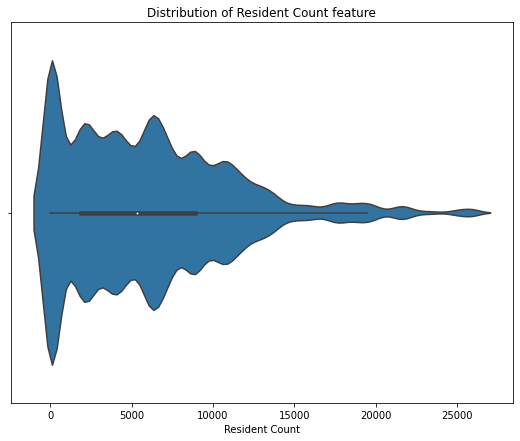

In [13]:
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='Resident Count')
plt.title('Distribution of Resident Count feature')

In [14]:
df.skew(numeric_only=True)['Resident Count']

1.0484746095288129

We see that this feature is skewed, with a high proportion of zeros.  A square root transformation may help reduce the skewness.

Text(0.5, 1.0, 'Distribution of square root of the Resident Count feature')

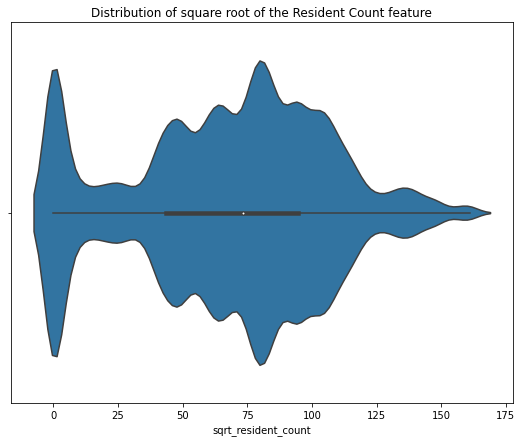

In [15]:
df['sqrt_resident_count'] = np.sqrt(df['Resident Count'])
df = df.drop(columns='Resident Count')
plt.figure(figsize=(9, 7))
sns.violinplot(data=df, x='sqrt_resident_count')
plt.title('Distribution of square root of the Resident Count feature')

In [16]:
df.skew(numeric_only=True)['sqrt_resident_count']

-0.22059764989237376

In [17]:
df.Year.value_counts()

2018    15566
2017    15222
2016    14727
2015    14654
2019    12966
2014    11731
2013    10235
2012     4899
Name: Year, dtype: int64

This feature looks fine.  We will leave it as is and normalize later.

For the remaining 2 input variables, Sector and Month, we will apply a target encoding.  However, we must first split the data into training and testing batches in order to fit the target encoder.

In [18]:
y = df['Crime Count']
x = df.drop(columns='Crime Count')
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

In [19]:
df.Sector.value_counts()

CENTRE       25386
SOUTH        16359
NORTHEAST    16336
NORTHWEST    10094
WEST          8918
NORTH         8325
EAST          7927
SOUTHEAST     6655
Name: Sector, dtype: int64

My original thought for this feature was to apply a $\sin$-$\cos$ encoding whereby we map these values to the unit circle and apply $\sin$ and $\cos$ functions to create two new feature.  This preserves the cyclic structure of the variable and would likely work best in a deep learning scenario. However, for a linear regression model, this is not the best as we are introducing some non-linear behaviour into the feature.  Thus, I decided to go for a target encoding.  Here, we map each value to the mean its corresponding target variable values.  It is important we performed the train-test split first so that we didn't introduce information about the testing data into the training data.

In [20]:
# # Old method
# angles = {'EAST': 0,
#           'NORTHEAST': np.pi/4, 
#           'NORTH': np.pi/2,
#           'NORTHWEST': 3*np.pi/4,
#           'WEST': np.pi,
#           'SOUTHWEST': 5*np.pi/4,
#           'SOUTH': 3*np.pi/2,
#           "SOUTHEAST": 7*np.pi/4}
# df['sector_sin'] = [np.sin(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
# df['sector_cos'] = [np.cos(angles[sector]) if sector != 'CENTRE' else 0 for sector in df.Sector]
# df = df.drop(columns='Sector')


target_encoder = ce.TargetEncoder(cols='Sector')
target_encoder.fit(x_train.Sector, y_train)
x_train.Sector = target_encoder.transform(x_train.Sector)
x_test.Sector = target_encoder.transform(x_test.Sector)

/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:124: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/category_encoders/target_encoder.py:129: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


In [21]:
df.Month.value_counts()

OCT    9473
AUG    9451
SEP    9326
NOV    9053
DEC    8893
MAY    8220
APR    7970
MAR    7824
JUL    7782
JAN    7679
FEB    7481
JUN    6848
Name: Month, dtype: int64

We will apply the same method to the Month feature as we did to the Sector feature.

In [22]:
# # Old method
# months = ['JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
# month_angles = {month: i*np.pi/6 for i , month in enumerate(months)}
# df['month_sin'] = np.sin([month_angles[month] for month in df.Month])
# df['month_cos'] = np.cos([month_angles[month] for month in df.Month])
# df = df.drop(columns='Month')


target_encoder = ce.TargetEncoder(cols='Month')
target_encoder.fit(x_train.Month, y_train)
x_train.Month = target_encoder.transform(x_train.Month)
x_test.Month = target_encoder.transform(x_test.Month)

In [23]:
x_train

,Sector,Group Category,Year,Month,Community Name_ABBEYDALE,Community Name_ACADIA,Community Name_ALBERT PARK/RADISSON HEIGHTS,Community Name_ALTADORE,Community Name_ARBOUR LAKE,Community Name_BANFF TRAIL,...,Category_Commercial Break & Enter,Category_Commercial Robbery,Category_Physical Disorder,Category_Residential Break & Enter,Category_Social Disorder,Category_Street Robbery,Category_Theft FROM Vehicle,Category_Theft OF Vehicle,Category_Violence Other (Non-domestic),sqrt_resident_count
42865,6.865178,1,2016,8.597938,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,140.221254
91446,11.438431,0,2013,7.783445,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,50.418251
66374,6.865178,1,2016,7.375373,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,112.556652
79106,6.554016,1,2016,8.282121,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,41.255303
13404,11.438431,0,2018,7.031382,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,152.377820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21243,11.438431,0,2018,7.144448,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,31.591138
45891,4.921272,1,2016,7.144448,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,51.855569
42613,6.554016,1,2017,8.395811,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,103.247276
43567,11.438431,1,2017,8.282121,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,65.962110


Now we look at the target variable Crime Count.

Text(0.5, 1.0, 'Crime Count distribution')

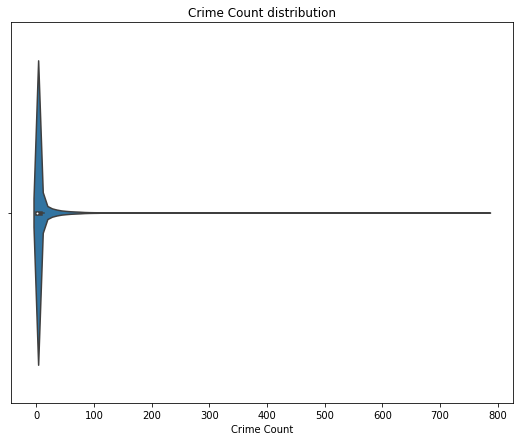

In [24]:
plt.figure(figsize=(9, 7))
sns.violinplot(x=y_train)
plt.title('Crime Count distribution')

In [25]:
y_train.skew()

14.848331856926077

This variable is highly skewed, so we should likely apply a transformation to reduce its skew.  From testing, I found applying a logarithmic transform followed by a square root transform produced the best results.  Thus we apply that here.

Text(0.5, 1.0, 'Transformed Crime Count Feature')

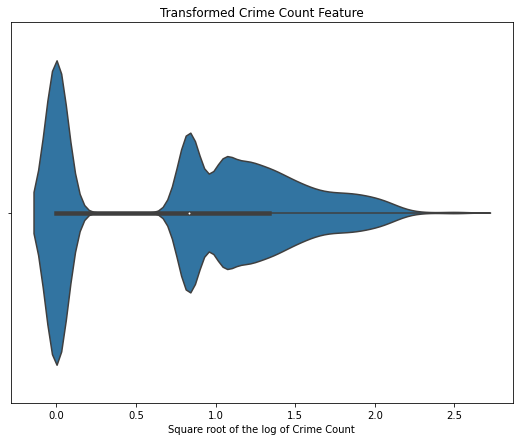

In [26]:
y_train = np.sqrt(np.log(y_train))
plt.figure(figsize=(9, 7))

sns.violinplot(x=y_train)
plt.xlabel('Square root of the log of Crime Count')
plt.title('Transformed Crime Count Feature')

In [27]:
y_train.skew()

-0.0023810653049187143

As you can see from the above, this significantly reduces the skewness of the dataset.

In [28]:
## This code block was used to determing the number of communities to keep when
## performing the one-hot encoding on the Community Name feature


# Rs = []
# mses = []
# vals = list(range(5, 301, 5))
# for i in vals:
#   dfn = df.copy()
#   top = dfn['Community Name'].value_counts()[:i].index
#   dfn.loc[~df['Community Name'].isin(top), 'Community Name'] = 'Other'
#   dfn = pd.get_dummies(dfn, columns=['Community Name'])

#   y = dfn['Crime Count']
#   x = dfn.drop(columns='Crime Count')
#   x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=0)

#   scaler = StandardScaler().fit(x_train)
#   x_train = scaler.transform(x_train)
#   x_test = scaler.transform(x_test)

#   lr = LinearRegression()
#   lr.fit(x_train, y_train)

#   y_pred = lr.predict(x_test)

#   # Transform the predictions back to the counts.
#   y_pred = np.exp(y_pred**2)

#   mse = mean_squared_error(y_test, y_pred)
#   r = r2_score(y_test, y_pred)
#   print(f'{i}  |  mse={mse}  |  r={r}')
#   Rs.append(r)
#   mses.append(mse)

# sns.scatterplot(x=vals, y=Rs)
# plt.show()
# sns.scatterplot(x=vals, y=mses)
# plt.show()

Before fitting, we standardize training and testing input features data based on the training data.

In [29]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [30]:
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [31]:
# Predict the square root of the log of the crime count.
y_pred = lr.predict(x_test)
y_pred_train = lr.predict(x_train)

# Transform the y values back to the counts.
y_pred = np.exp(y_pred**2)
y_pred_train = np.exp(y_pred_train**2)
y_train = np.exp(y_train**2)

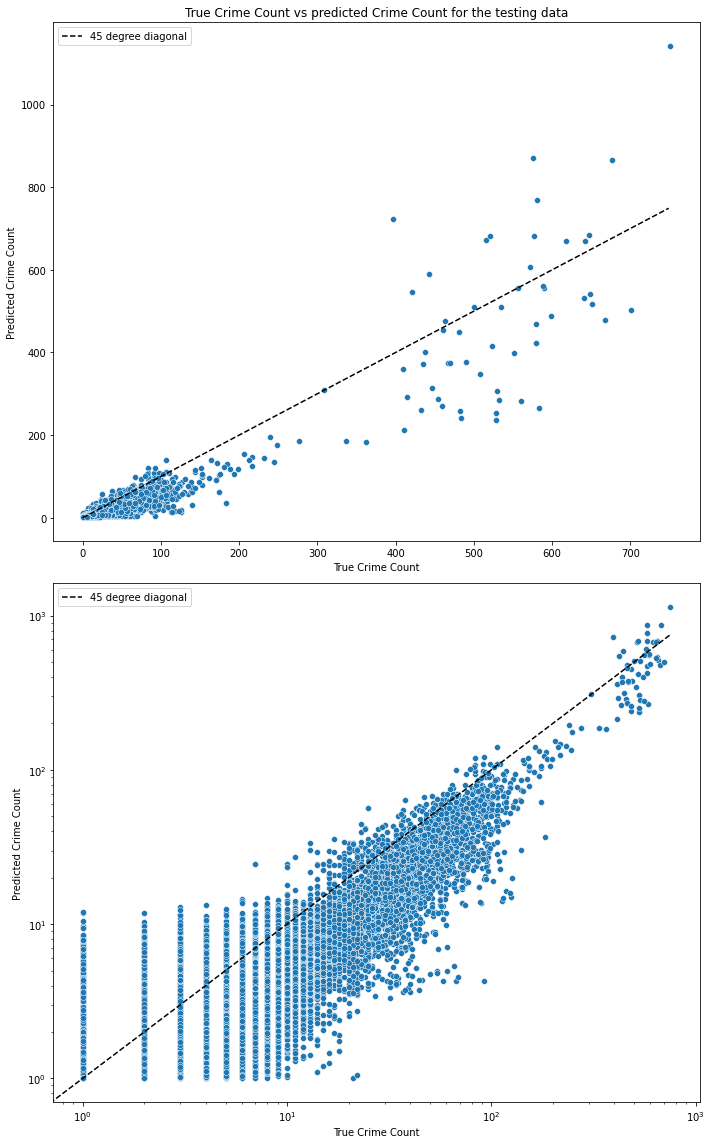

In [32]:
plt.figure(figsize=(10, 16))
for i in range(2):
  plt.subplot(2, 1, i+1)
  sns.scatterplot(x=y_test, y=y_pred)
  plt.xlabel('True Crime Count')
  plt.ylabel('Predicted Crime Count')
  plt.plot(range(0, 750), range(0, 750), 'k--', label='45 degree diagonal')
  if i == 0:
    plt.title('True Crime Count vs predicted Crime Count for the testing data')
  if i == 1:
    plt.xscale('log')
    plt.yscale('log')
  plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('test_res.png', dpi=300)

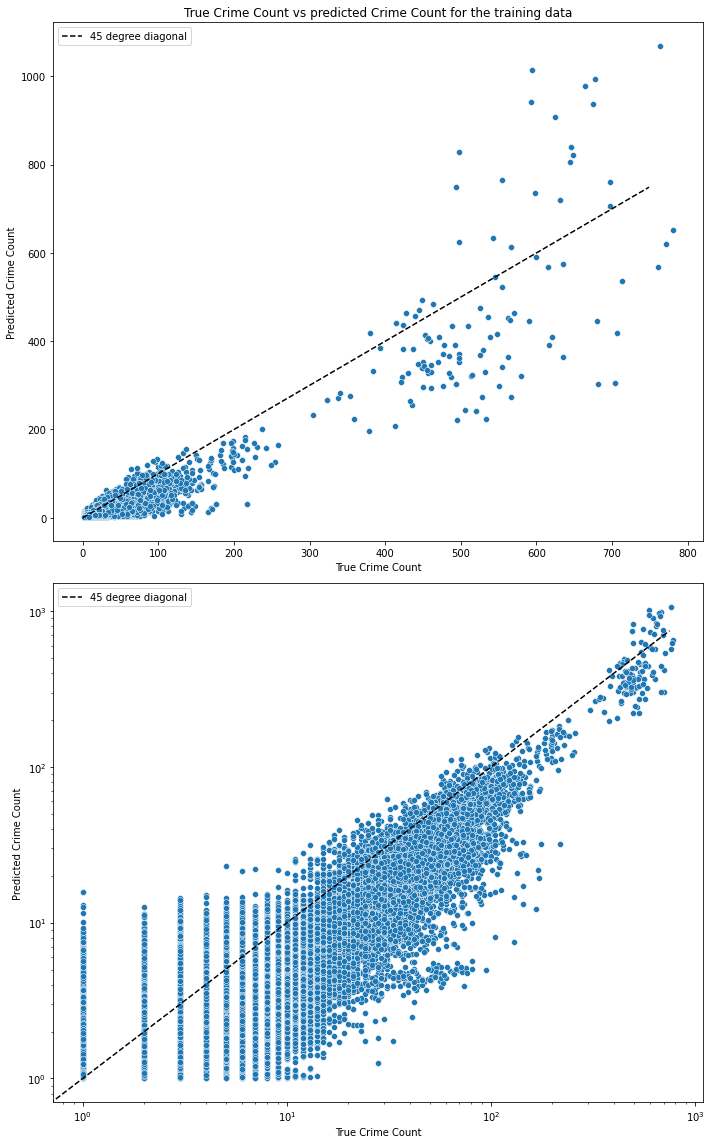

In [33]:
plt.figure(figsize=(10, 16))
for i in range(2):
  plt.subplot(2, 1, i+1)
  sns.scatterplot(x=y_train, y=y_pred_train)
  plt.xlabel('True Crime Count')
  plt.ylabel('Predicted Crime Count')
  plt.plot(range(0, 750), range(0, 750), 'k--', label='45 degree diagonal')
  if i == 0:
    plt.title('True Crime Count vs predicted Crime Count for the training data')
  if i == 1:
    plt.xscale('log')
    plt.yscale('log')
  plt.legend(loc='upper left')
plt.tight_layout()
# plt.savefig('train_res.png', dpi=300)

In [34]:
print(f'MSE for test data: {mean_squared_error(y_test, y_pred)}')
print(f'MSE for train data: {mean_squared_error(y_train, y_pred_train)}')

MSE for test data: 119.792451451587
MSE for train data: 118.12697687629034


In [35]:
print(f'MAE for test data: {mean_absolute_error(y_test, y_pred)}')
print(f'MAE for train data: {mean_absolute_error(y_train, y_pred_train)}')

MAE for test data: 3.6315064215436252
MAE for train data: 3.6251489923535885


In [36]:
print(f'Coefficient of Determination for test data: {r2_score(y_test, y_pred)}')
print(f'Coefficient of Determination for train data: {r2_score(y_train, y_pred_train)}')

Coefficient of Determination for test data: 0.838818119136924
Coefficient of Determination for train data: 0.8268441247126399
